In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import base64, io, time, gym
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display as ipythondisplay
import glob
import typing

In [3]:
env: gym.Env = gym.make('LunarLander-v2')
print('observation space:', env.observation_space)
print('action space:', env.action_space)


observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)


In [4]:
class Qnn(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(Qnn, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
BUFFER_SIZE: int = 100000
BATCH_SIZE: int = 64
GAMMA: float = 0.99
TAU: float = 1e-3
LR: float = 5e-4
UPDATE_EVERY: int = 4
STATE_SIZE: int = env.observation_space.shape[0]
ACTION_SIZE: int = env.action_space.n
SEED: int = 0

In [6]:
device: str = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from typing import Tuple
class ReplayBuffer():
    def __init__(self, action_size: int, buffer_size: int, batch_size: int, seed: int):
        self.action_size: int = action_size
        self.memory: deque = deque(maxlen=buffer_size)
        self.batch_size: int = batch_size
        self.experience: namedtuple = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed: int = random.seed(seed)

    def add(self, state: Tuple, action: int, reward: float, next_state: np.ndarray, done: bool):
        e: namedtuple = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self) -> Tuple:
        experiences: Tuple = random.sample(self.memory, k=self.batch_size)
        states: torch.Tensor = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions: torch.Tensor = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards: torch.Tensor = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states: torch.Tensor = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones: torch.Tensor = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self) -> int:
        return len(self.memory)

In [8]:
class Agent():
    def __init__(self, state_size: int, action_size: int, seed: int):
        self.state_size: int = state_size
        self.action_size: int = action_size
        self.seed: int = random.seed(seed)
        self.qnn_local: Qnn = Qnn(state_size, action_size).to(device)
        self.qnn_target: Qnn = Qnn(state_size, action_size).to(device)
        self.optimizer: optim = optim.Adam(self.qnn_local.parameters(), lr=LR)
        self.memory: ReplayBuffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step: int = 0
    
    def step(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences: Tuple = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state: np.ndarray, eps: float = 0.) -> int:
        state: torch.Tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnn_local.eval()
        with torch.no_grad():
            action_values: torch.Tensor = self.qnn_local(state)
        self.qnn_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences: Tuple, gamma: float):
        states, actions, rewards, next_states, dones = experiences
        q_target_next: torch.Tensor = self.qnn_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_target: torch.Tensor = rewards + (gamma * q_target_next * (1 - dones))
        q_expected: torch.Tensor = self.qnn_local(states).gather(1, actions)
        loss: torch.Tensor = F.mse_loss(q_expected, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnn_local, self.qnn_target, TAU)
    
    def soft_update(self, local_model: nn.Module, target_model: nn.Module, tau: float):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
            

In [ ]:
import typing
from typing import List, Tuple, Deque


def DQN(n_episodes: int = 2000, max_t: int = 1000, eps_start: float = 1.0, eps_end: float = 0.01, eps_decay: float = 0.995):
    scores: List[float] = []
    scores_window: deque = deque(maxlen=100)
    eps: float = eps_start
    for i_episode in range(1, n_episodes + 1):
        state: np.ndarray = env.reset()[0]
        score: float = 0
        for t in range(max_t):
            env.render(mode='rgb_array')
            action: int = agent.act(state, eps)
            next_state, reward, terminate, truncated, info = env.step(action)
            agent.step(state, action, reward, next_state, terminate)
            state: np.ndarray = next_state
            score += reward
            
            if terminate or truncated:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(
            i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode - 100, np.mean(scores_window)))
            torch.save(agent.qnn_local.state_dict(), 'checkpoint.pth')
            break
    env.close()
    return scores


agent: Agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=0)
scores: List[float] = DQN()


# SARSA for Lunar Lander

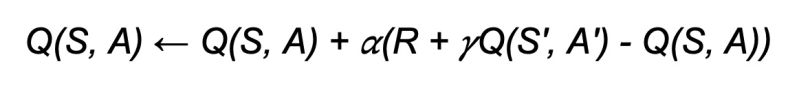

### Create the environment

In [56]:
def create_env():
    return gym.make('LunarLander-v2')
    #env.render()

### Environment preview


In [57]:
def env_preview(env):
    env.reset()
    for dummy in range(100):
        env.render()
        state, reward, done, info = env.step(env.action_space.sample())
        if done:
            break
    env.close()

### Understanding the environment

In [58]:
def show_action_and_env_space(env):
    # Action space and environment space
    print("env.action_space", env.action_space)
    print("env.observation_space", env.observation_space)
    print("env.observation_space.high", env.observation_space.high)
    print("env.observation_space.low", env.observation_space.low)

### Buckets
We need to discretize the environment values (observation vector); to do this, we are going to use buckets for each dimension of the observation vector. If the real value of the first dimension of the observation vector is in <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">[</mo>
  <mi>a</mi>
  <mo>,</mo>
  <mi>b</mi>
  <mo stretchy="false">]</mo>
</math>
 and if the number of buckets for that dimension is 
, we are going to interpolate that real value into an integer in <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">[</mo>
  <mn>0</mn>
  <mo>,</mo>
  <mi>n</mi>
  <mo>&#x2212;</mo>
  <mn>1</mn>
  <mo stretchy="false">]</mo>
</math>


In [59]:
def set_buckets_and_actions():
    number_of_buckets = (5,5,5,5,5,5,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n
    
    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))
    
    #New bound values for each dimension
    state_value_bounds[0] = [-1,1]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]
    
    return number_of_buckets, number_of_actions, state_value_bounds

In [60]:
def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

### Create the Q-table

In [63]:
def initialize_q_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

### Create Returns_table

In [64]:
def initialize_visits_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

In [65]:
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 - 
                              math.log10((episode + 1) / (total_train_episodes*0.1))))

In [66]:
def choose_action(q_table, bucket_state, epsilon):
    if (np.random.random() <= epsilon):
        #print("random")
        return env.action_space.sample() #Exploration
    else:
        #print("greedy")
        return np.argmax(q_table[bucket_state]) #Eplotation

In [67]:
# ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    # Control variables
    total_reward = 0
    done = False
        
    trayectory = []
        
    # Initialize S
    # Reset the environment getting the initial state
    bucket_state = bucketize(env.reset())

    # Loop for each step of episode:
    for step in range(max_env_steps):
            #print("step ", step)

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)
            #print(q_table[bucket_state])
            #print("action ", action)

        # Take the action A, observe R, S'
        new_state, reward, done, info = env.step(action)
        bucket_new_state = bucketize(new_state)
            #print("reward ", reward)
            
        trayectory.append([bucket_state, action, reward])
            
        # new_state is now the current state
        bucket_state = bucket_new_state

        total_reward += reward

        # if done, finish the episode
        if done:
            break
    
    return trayectory, total_reward

### Explore state (observation) space

### Generate some samples from the state space 

### Explore the action space and generate some samples from it